Мы получили набор данных с действиями пользователей. Нам необходимо провести общий анализ пользователей, чтобы понять, кто они, откуда они, как они используют данные и т.д. Кроме того, необходимо проанализировать данные А/В-теста, который был проведен и разделил пользователей на группы 0 и 1.

In [27]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [28]:
#Загрузим наш датайфрейм и посмотрим в целом на данные
df = pd.read_csv('posts_info.csv', index_col=0)
df.head()

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,14997,2121,view,2022-12-03 20:40:29,1,23,Russia,Moscow,Android,ads,1
1,128596,2072,view,2022-12-03 20:40:29,1,31,Russia,Moscow,iOS,organic,1
2,134456,2068,view,2022-12-03 20:40:29,1,36,Russia,Buynaksk,Android,organic,1
3,134475,2018,view,2022-12-03 20:40:29,0,18,Russia,Artëm,iOS,organic,1
4,10062,2024,view,2022-12-03 20:40:30,1,27,Russia,Khuchni,iOS,ads,1


Теперь пройдемся по столбцам, которые у нас есть. Вот описание каждого из них:
1. user_id: Идентификатор пользователя. Это уникальный номер, присвоенный каждому пользователю.
2. post_id: Идентификатор поста. Это уникальный номер, присвоенный каждому посту.
3. action: Действие пользователя. Этот столбец указывает на конкретное действие, выполненное пользователем.
4. time: Время совершения действия. Это дата и время, когда пользователь выполнил действие.
5. gender: Пол пользователя. (0 - женщина, 1 - мужчина)
6. age: Возраст пользователя. Этот столбец указывает на возраст пользователя.
7. country: Страна пользователя. Этот столбец указывает на страну, из которой пользователь.
8. city: Город пользователя. Этот столбец указывает на город, в котором находится пользователь.
9. os: Операционная система пользователя. Этот столбец указывает на операционную систему, используемую пользователем.
10. source: Источник перехода пользователя. Этот столбец указывает на источник, откуда пришел пользователь.
11. exp_group: Группа эксперимента. Этот столбец указывает на группу, к которой принадлежит пользователь в рамках эксперимента.


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1632232 entries, 0 to 1632231
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1632232 non-null  int64 
 1   post_id    1632232 non-null  int64 
 2   action     1632232 non-null  object
 3   time       1632232 non-null  object
 4   gender     1632232 non-null  int64 
 5   age        1632232 non-null  int64 
 6   country    1632232 non-null  object
 7   city       1632232 non-null  object
 8   os         1632232 non-null  object
 9   source     1632232 non-null  object
 10  exp_group  1632232 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 149.4+ MB


In [30]:
print(f'Размерность данного датафрейма составялет {df.shape[0]} строк и {df.shape[1]} столбцов')

Размерность данного датафрейма составялет 1632232 строк и 11 столбцов


In [31]:
# Сразу создадим копию нашего датафрейма, с целью если что-то идет не так, 
# у нас всегда будет оригинальная копия данных, с которой мы сможем работать
data = df.copy()
# Переведем значение столбца time из формата строкового типа в формат даты и время с явным указанием необходимого нам формата
data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S')
data['time'].dtype

dtype('<M8[ns]')

In [32]:
# Рассмотрим есть ли у нас пропуски в данных
data.isnull().mean()

user_id      0.0
post_id      0.0
action       0.0
time         0.0
gender       0.0
age          0.0
country      0.0
city         0.0
os           0.0
source       0.0
exp_group    0.0
dtype: float64

# Проведем разведочный анализ данных (EDA)

### Расмотрим пользователей в разрезе стран, пола и возраста

In [33]:
# Количество уникальных пользователей в данной выборке
data['user_id'].nunique()

20048

In [34]:
# Для уменьшения объема кода напишем функцию, которая будет визуализировать количество пользователей в процентном соотношении
# по выбранному столбцу

def visualization(df, col):
    # Группируем данные по группе эксперимента и вычисляем количество уникальных пользователей
    grouped_data = df.groupby(['exp_group', col])['user_id'].nunique().reset_index(name='count')\
    .sort_values(by=['count', col], ascending=[False,True])
    
    # Вычисляем общее количество пользователей в каждой группе эксперимента
    total_users = grouped_data.groupby('exp_group')['count'].transform('sum')
    
    # Вычисляем процентное соотношение каждого значения в столбце внутри каждой группы
    grouped_data['percentage'] = grouped_data['count'] / total_users * 100
    
    if col == 'city':
        grouped_data = grouped_data.head(10)
    # Создаем barplot для каждой группы
    for group_name in grouped_data['exp_group'].unique():
        group_data = grouped_data[grouped_data['exp_group'] == group_name]
        plt.figure(figsize=(10, 6))
        bars = sns.barplot(x=group_data[col], y=group_data['percentage'], alpha=0.8)
        plt.title(f'Процентное соотношение пользователей по {col} в {"контрольной" if group_name == 0 else "тестовой"} группе')
        plt.ylabel('Процент пользователей', fontsize=12)
        plt.xlabel(f'{col}', fontsize=12)
        plt.xticks(rotation=45)
        
        # Добавляем значение над каждым столбцом в процентах
        for bar in bars.patches:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', va='bottom')
        
        plt.show()

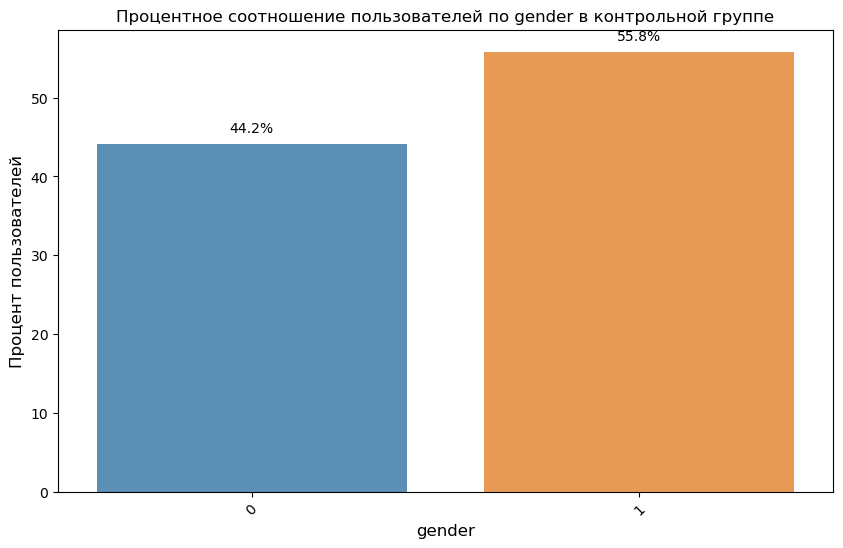

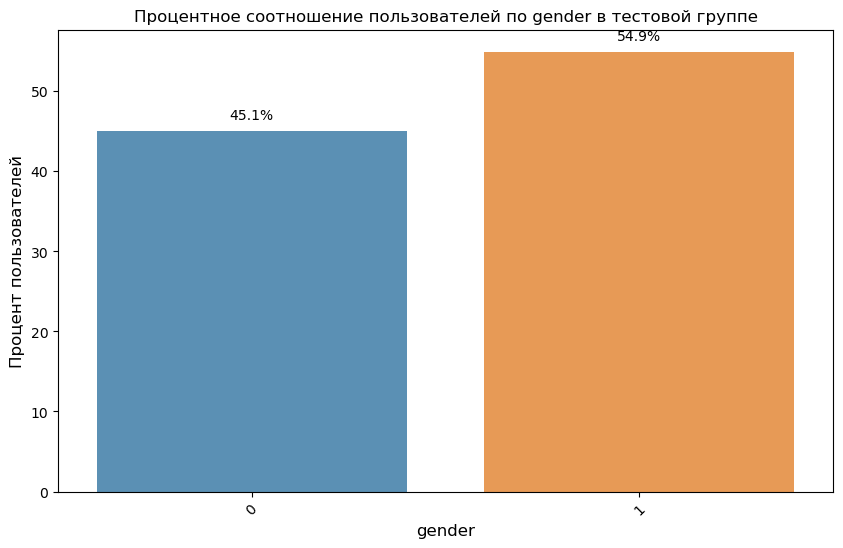

In [35]:
visualization(data, 'gender')

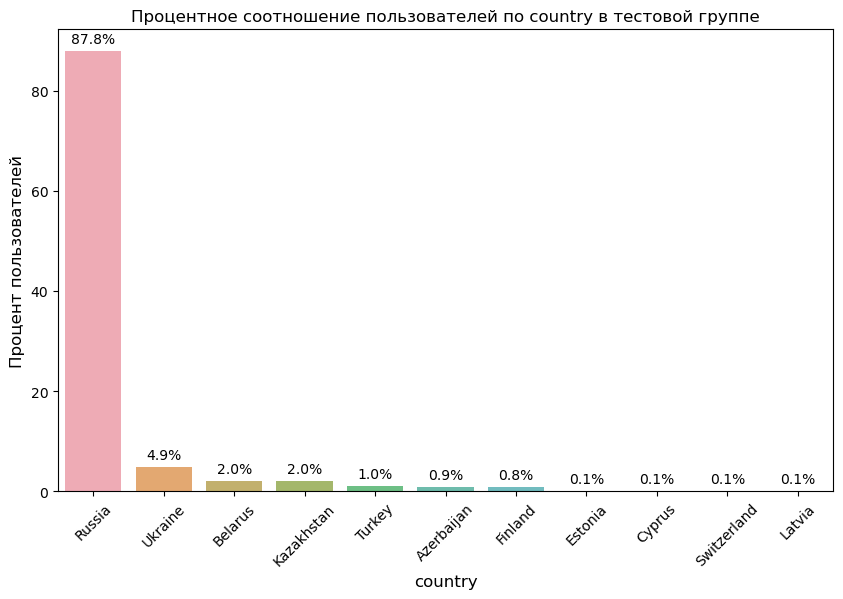

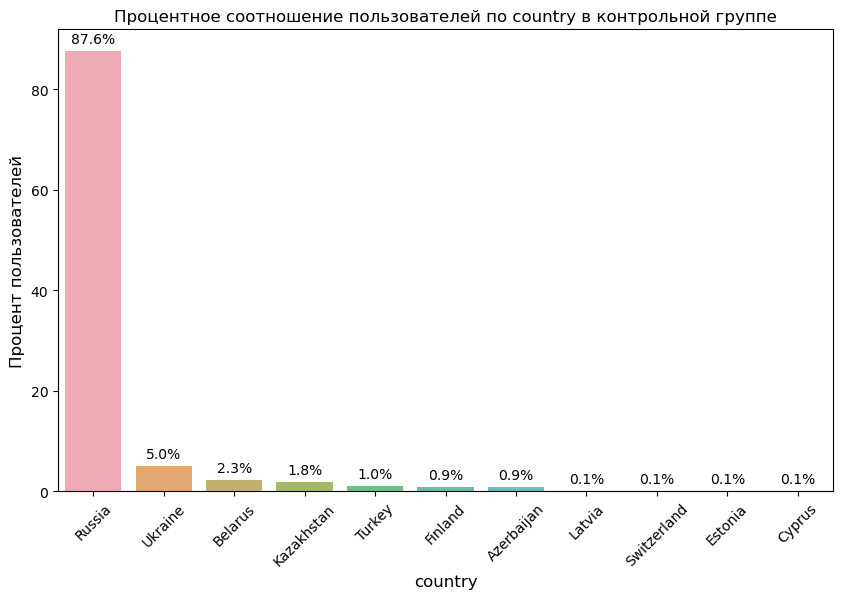

In [36]:
# Из каких стран данные пользователи
visualization(data, 'country')

In [37]:
# Для визуализации возраста пользователей разобъем их на группы
bins = [0, 18, 30, 50, 100]
labels = ['child (0-17)', 'young (18-29)', 'adult (30-49)', 'old (50+)']
data['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)

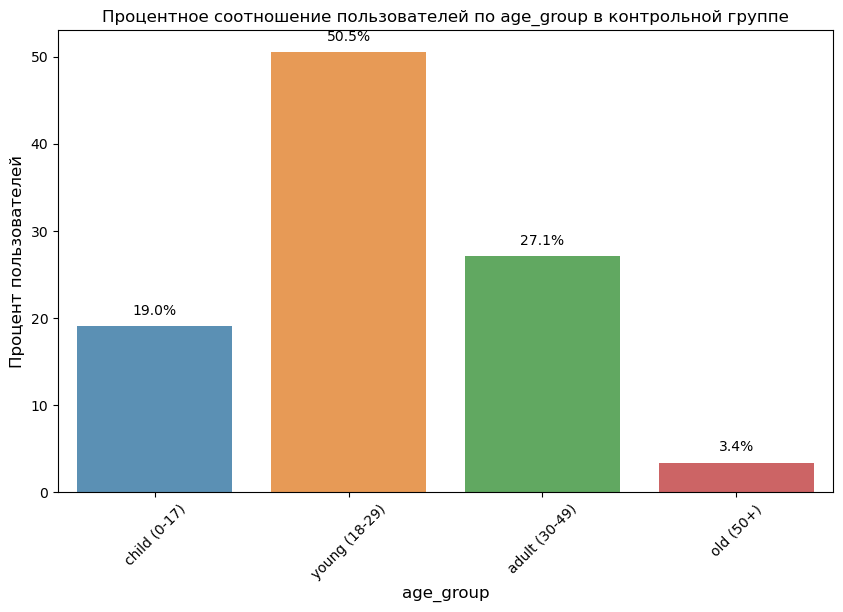

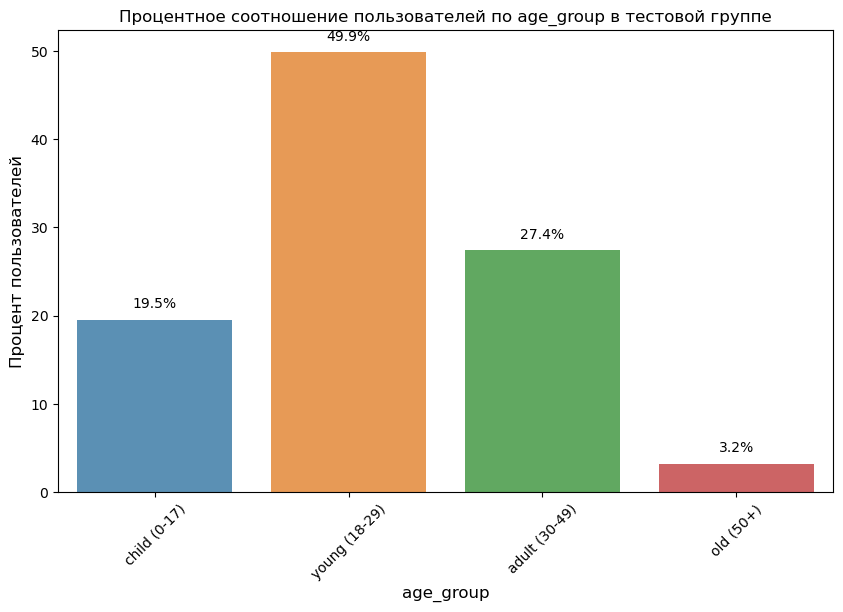

In [38]:
visualization(data, 'age_group')

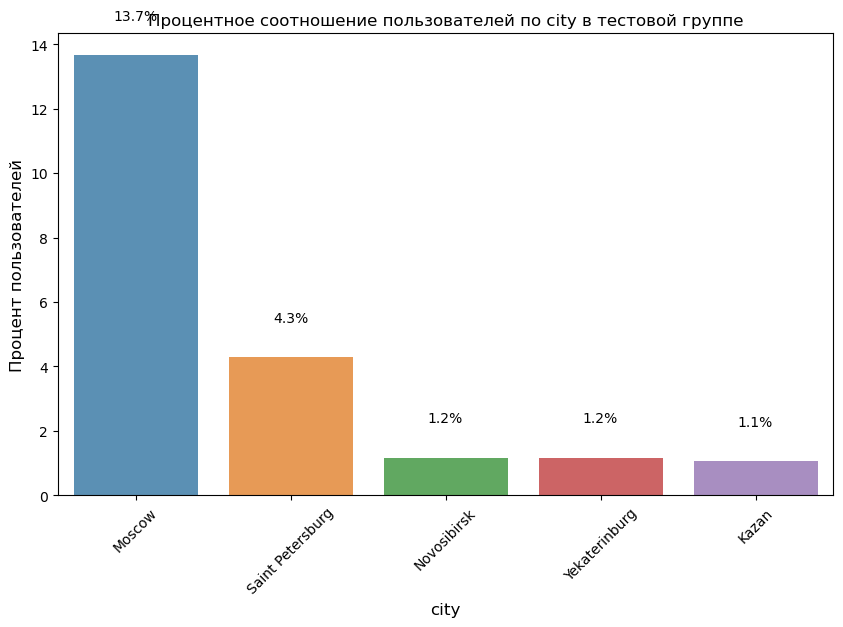

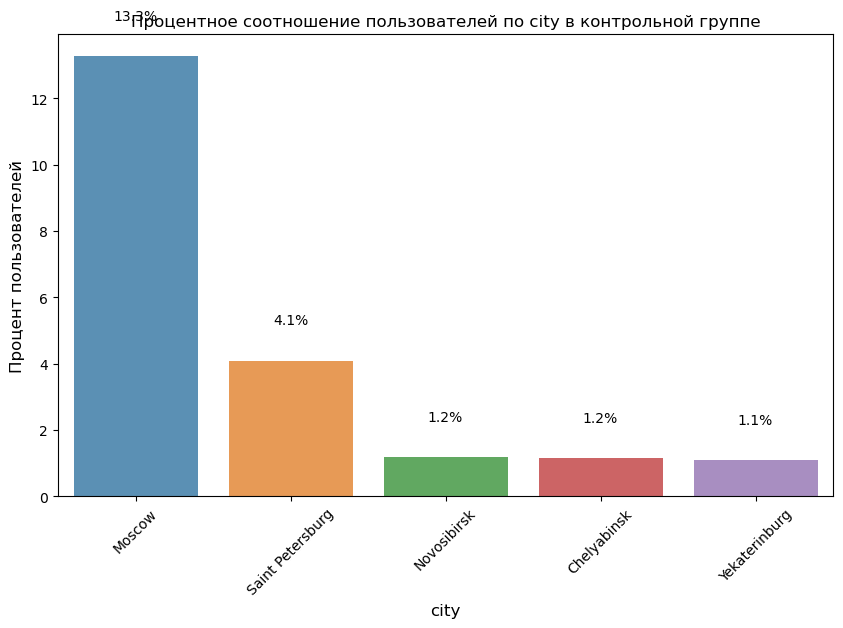

In [39]:
# Топ 5 городов пользователей
visualization(data, 'city')

### Рассмотрим активность пользователей по времени суток

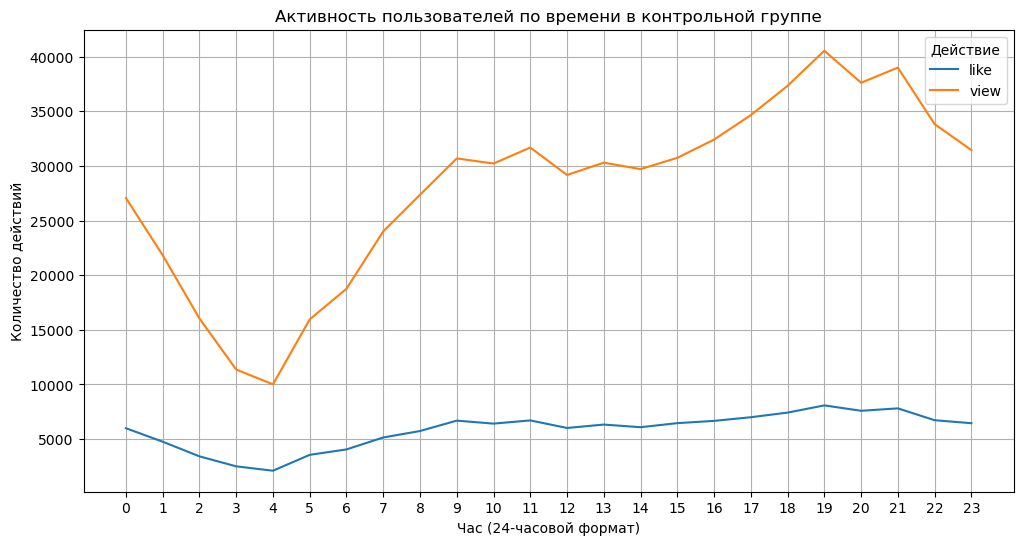

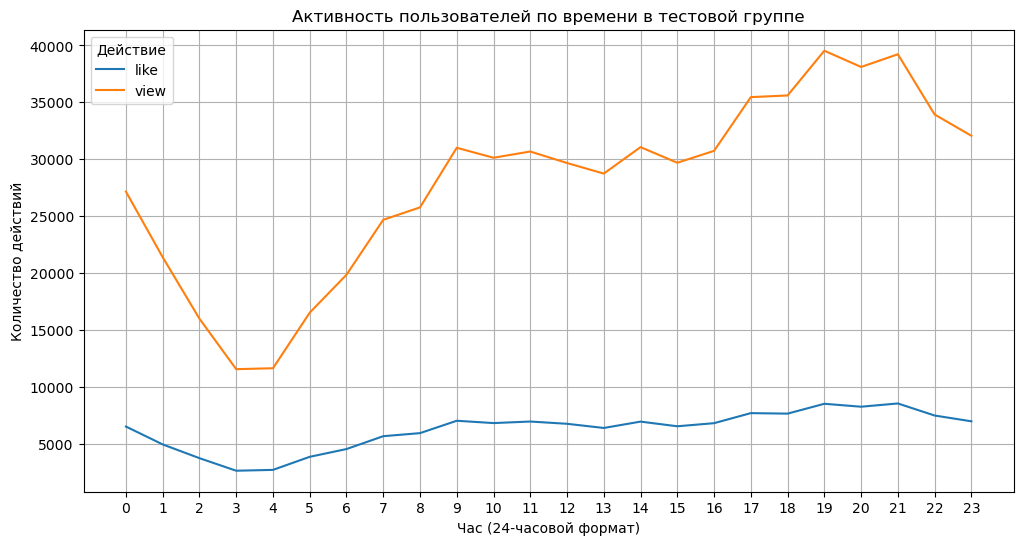

In [41]:
data['hour'] = data['time'].dt.hour
grouped = data.groupby('exp_group')
for group_name, group_data in grouped:
    activity_by_hour = group_data.groupby(['hour', 'action'])['time'].count().reset_index().rename(columns={'time': 'count'})

    # Визуализируем
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=activity_by_hour, x='hour', y='count', hue='action')
    plt.title(f'Активность пользователей по времени в {"контрольной" if group_name == 0 else "тестовой"} группе')
    plt.xlabel('Час (24-часовой формат)')
    plt.ylabel('Количество действий')
    plt.legend(title='Действие')
    plt.xticks(range(24))
    plt.grid(True)
    plt.show()

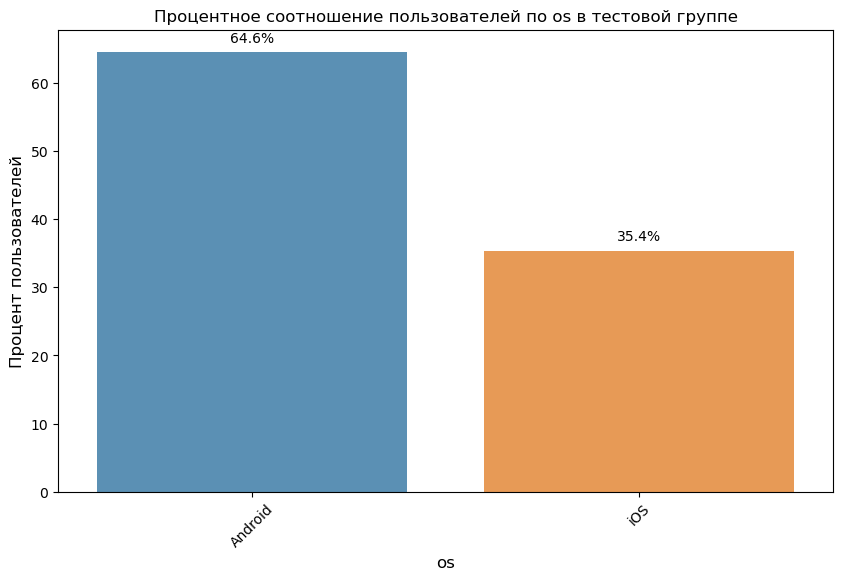

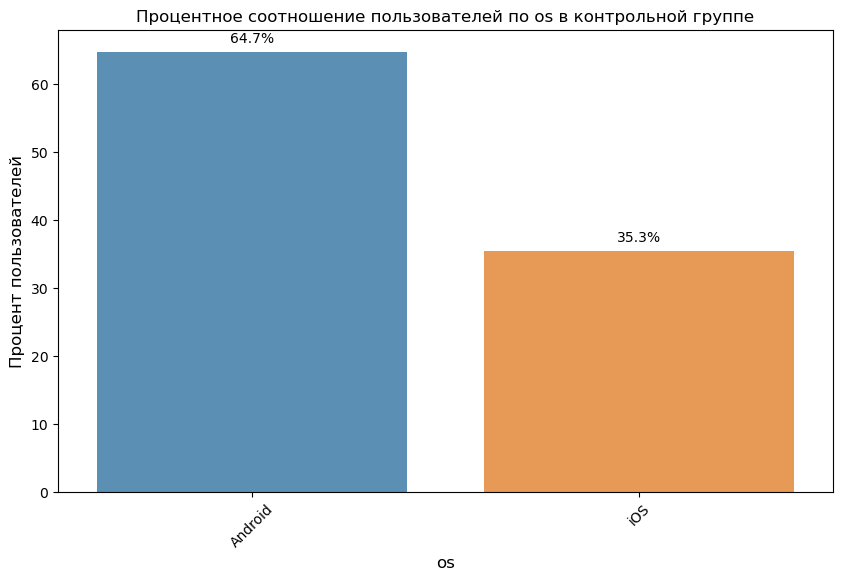

In [42]:
# Рассмотрим количество пользователей в зависимости от операционной системы
visualization(data, 'os')

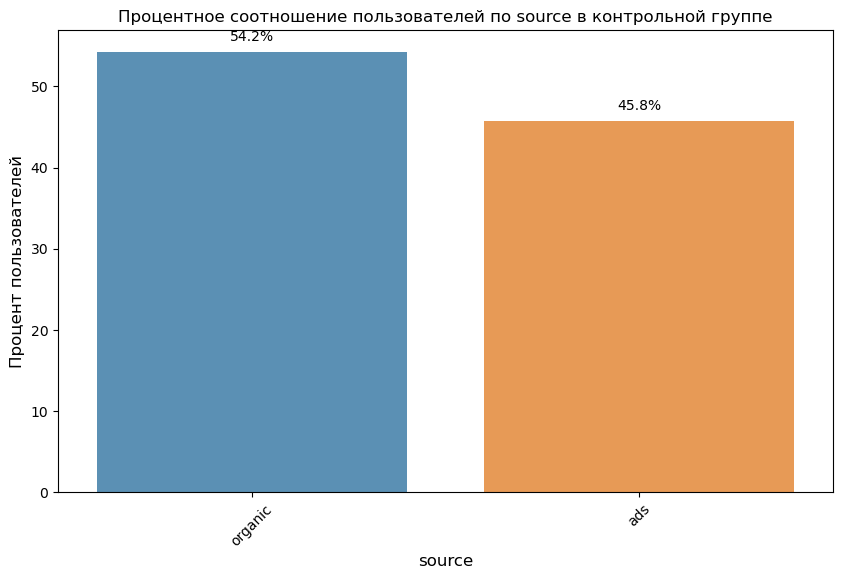

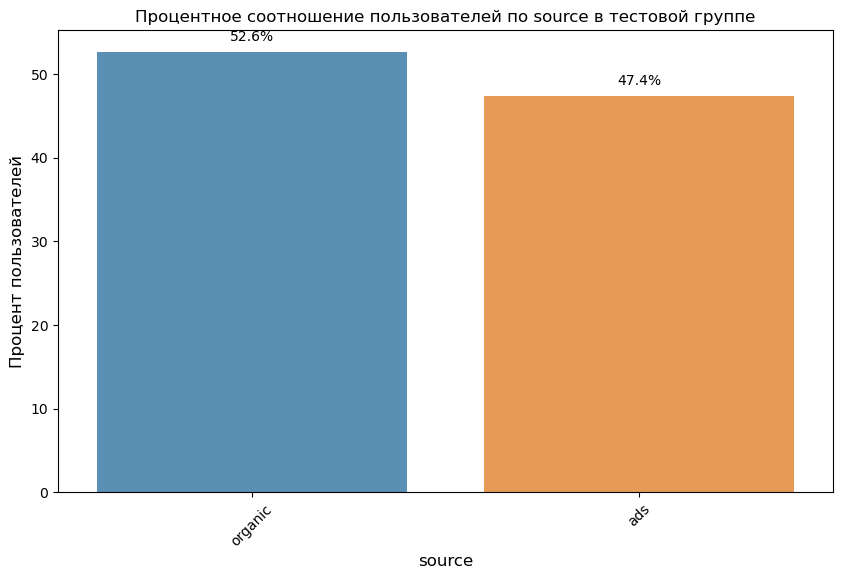

In [43]:
visualization(data, 'source')

# Тестирование гипотез

У нас шел тест с  2022-12-02 по 2022-12-08 включительно  
В данном тесте пользователи были разбиты на 2 группы:
 - exp_group = 0 - Все по-старому
 - exp_group = 1 - Создана новая система рекомендаций, основанная на лайках, похожих на вас людей

In [44]:
# Проверим есть ли у нас пользователи, которые были в контрольной и тестируемой группе во время эксперимента
df.groupby('user_id')['exp_group'].nunique().max()

1

In [45]:
# Сгруппируем пользователей и посчитаем их просмотры и лайки по постам
user_data = data.groupby(['user_id', 'exp_group']).agg(views=('action', lambda x: (x=='view').sum()),
                                           likes=('action', lambda x: (x=='like').sum())).reset_index()

# Создадим новую метрику по каждому пользователю как отношение просмотров к лайкам и назовем ее ctr
user_data['ctr'] = user_data['likes'] / user_data['views']

In [46]:
user_data.head()

,user_id,exp_group,views,likes,ctr
0,200,1,16,5,0.312500
1,201,0,62,16,0.258065
2,207,1,53,14,0.264151
3,212,0,27,7,0.259259
4,222,0,12,2,0.166667


In [47]:
user_data.shape

(20048, 5)

In [59]:
# Сколько людей у нас в каждой группе
user_data['exp_group'].value_counts(normalize=True)

exp_group
1    0.501247
0    0.498753
Name: proportion, dtype: float64

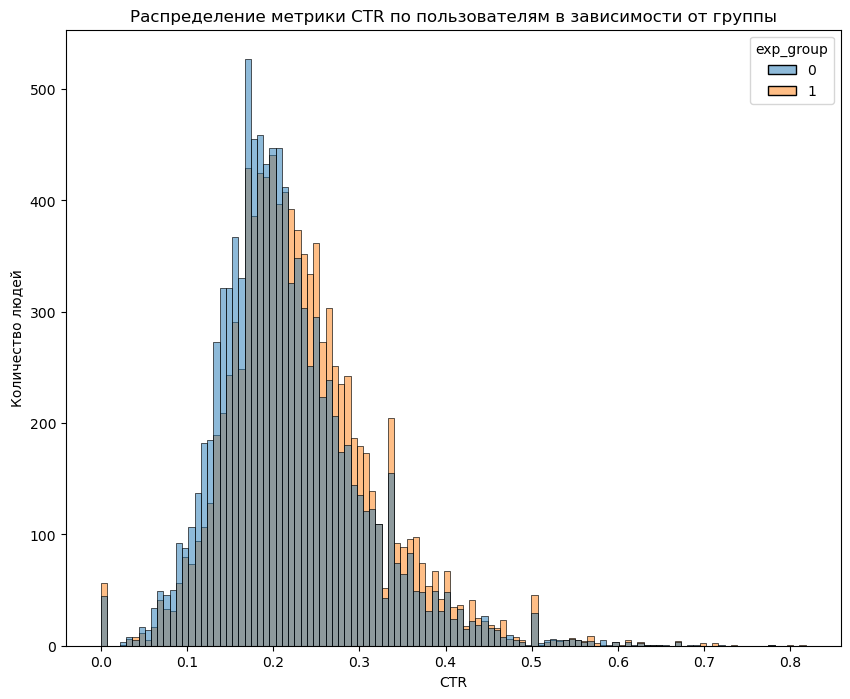

In [48]:
# Рассмотрим распределение метрики CTR в зависимости от группы (0 - контрольная, 1 - тестовая)
plt.figure(figsize=(10, 8))
sns.histplot(data = user_data, 
              x='ctr', 
              hue='exp_group', 
              alpha=0.5,
              kde=False)
plt.title("Распределение метрики CTR по пользователям в зависимости от группы")
plt.ylabel("Количество людей")
plt.xlabel("CTR")
plt.show()

In [49]:
grouped_exp = user_data.groupby('exp_group').agg(mean=('ctr', 'mean'),
                                   median=('ctr', 'median'),
                                   std=('ctr', 'std'))
grouped_exp.index = ['control', 'test']
grouped_exp

,mean,median,std
control,0.215950,0.202899,0.083628
test,0.232624,0.220339,0.086247


На первый взгляд среднее экспериментальной группы больше тестовой на ~ 0.17, а медиана на ~0.174.  
Наша задача узнать это разница случайна или же разница статистически значима, и новая система рекомендаций постов повышает метрику CTR.

## t - тест Стьюдента

T-тест Стьюдента (Student's t-test) - это статистический тест, используемый для определения статистической значимости различия между двумя группами, которые могут быть связаны с различными распределениями. Вот некоторые основные требования для проведения t-теста Стьюдента:
1. Независимость: Наблюдения в одной группе не должны влиять на наблюдения в другой группе
2. Число наблюдений: Для t-теста Стьюдента обычно требуется не менее 30 наблюдений в каждой группе
3. Однородность дисперсии
4. Данные в каждой группе должны быть нормально распределены или иметь достаточно большое число наблюдений, чтобы использовать центральную предельную теорему.

Проверим, нормально ли распределены данные выборки
 - H_0- распределение нормальное
 - H_1- распределение ненормальное
 - уровень значимости (p-value) 0.05

In [50]:
def shapiro_test(data):   
    for group in data['exp_group'].unique():
        stat, p = stats.shapiro(data[data['exp_group'] ==0]['ctr'])
        print(f"Для группы {group} p-value составило {p}")
        # Интерпретация результатов
        alpha = 0.05
        if p > alpha:
            print('Выборка имеет нормальное распределение (НЕ отвергаем H_0)')
        else:
            print('Выборка не имеет нормальное распределение (отвергаем H_0)')


In [51]:
shapiro_test(user_data)

Для группы 1 p-value составило 0.0
Выборка не имеет нормальное распределение (отвергаем H_0)
Для группы 0 p-value составило 0.0
Выборка не имеет нормальное распределение (отвергаем H_0)


Проверить гомогенность дисперсии можно с помощью критерия Левена.
 - H_0- дисперсии однородны
 - H_1- дисперсии не однородны 
 - уровень значимости (p-value) 0.05

In [52]:
def levene_test(data):   
    # Разделяем данные на две группы
    group0 = data[data['exp_group'] == 0]['ctr']
    group1 = data[data['exp_group'] == 1]['ctr']

    # Применяем тест Левена
    stat, p = stats.levene(group0, group1)

    print(f"Для групп 0 и 1 p-value составило {p}")

    # Интерпретация результатов
    alpha = 0.05
    if p > alpha:
        print('Дисперсии однородны (НЕ отвергаем H0)')
    else:
        print('Дисперсии НЕ однородны (отвергаем H0)')

In [53]:
levene_test(user_data)

Для групп 0 и 1 p-value составило 0.0009361288519049566
Дисперсии НЕ однородны (отвергаем H0)


### Итог по t - тесту Стьюдента

Мы не можем применить t-тест Стьюдента, потому что данные не распределены нормально и гомогенность дисперсии отсутствует (поскольку дисперсии в обеих группах отличаются значительно). В этом случае нам придется использовать альтернативный тест

## Критерий Манна-Уитни (U - test)

Это непараметрический тест, который используется для сравнения рангов между двумя независимыми группами. Он не предполагает, что данные распределены нормально и не проверяет гомогенность дисперсии.

In [54]:
def mann_statistic(data):
    # Разделяем данные на две группы
    group0 = data[data['exp_group'] == 0]['ctr']
    group1 = data[data['exp_group'] == 1]['ctr']

    stat, p = stats.mannwhitneyu(group0, group1)

    print('Статистика Манна-Уитни:', stat)
    print('p-value:', p)

    # Интерпретация результатов
    alpha = 0.05
    if p > alpha:
        print('Нет статистически значимого различия между группами')
    else:
        print('Есть статистически значимое различие между группами')

In [55]:
mann_statistic(user_data)

Статистика Манна-Уитни: 43682792.0
p-value: 1.1952055473582936e-57
Есть статистически значимое различие между группами


### Итог по Критерию Манна-Уитни

Исходя из результатов теста Манна-Уитни, можно сделать вывод, что разница между группами статистически значима и наша система рекомендаций повышает метрику CTR и качество рекомендаций для наших пользователей.

## Bootstrap

Bootstrap-анализ основывается на следующем принципе: если у нас есть выборка из генеральной совокупности, мы можем создать множество новых выборок путем случайного сэмплирования с возвращением из исходной выборки. Эти новые выборки называются "bootstrap-выборками".
Затем мы вычисляем статистику по каждой из этих bootstrap-выборок. Например, если мы хотим оценить среднее генеральной совокупности, мы можем вычислить среднее для каждой bootstrap-выборки и использовать их среднее значение в качестве bootstrap-оценки среднего значения.
Мы же будем оценивать статистическую значимость с построением доверительного интервала

H_0 - данные распределения из одной генеральной совокупности и доверительный интервал для разницы средних включает 0  
H_1 - данные распределения из разных генеральных совокупностей и доверительный интервал для разницы средних НЕ включает 0

In [56]:
# Напишем функцию для проверки гипотезы с помощью бутстрап анализа и сделаем наглядную визуализацию
def bootstrap_and_plot(data, num_samples=1000, sample_size=100000, alpha=0.05):
    sample_means_control = []
    sample_means_test = []
    sample_diff_means = []

    for _ in tqdm(range(num_samples)):
        bootstrap_sample = data.sample(sample_size, replace=True)

        # Разделяем пользователей на группы
        control_group = bootstrap_sample[bootstrap_sample['exp_group'] == 0]['ctr']
        test_group = bootstrap_sample[bootstrap_sample['exp_group'] == 1]['ctr']

        # Вычисляем средние значения для контрольной и тестовой групп
        mean_control = control_group.mean()
        mean_test = test_group.mean()

        sample_means_control.append(mean_control)
        sample_means_test.append(mean_test)

        # Вычисляем разницу средних
        sample_diff_means.append(mean_control - mean_test)

    # Вычисляем доверительные интервалы
    lower_bound_test = np.percentile(sample_means_test, (alpha / 2) * 100)
    upper_bound_test = np.percentile(sample_means_test, (1 - alpha / 2) * 100)

    lower_bound_control = np.percentile(sample_means_control, (alpha / 2) * 100)
    upper_bound_control = np.percentile(sample_means_control, (1 - alpha / 2) * 100)

    lower_bound_diff = np.percentile(sample_diff_means, (alpha / 2) * 100)
    upper_bound_diff = np.percentile(sample_diff_means, (1 - alpha / 2) * 100)

    # Визуализация результатов
    plt.figure(figsize=(12, 10))
    
    # График для тестовой выборки
    plt.subplot(2, 2, 2)
    sns.histplot(sample_means_test, bins=30, edgecolor="black", alpha=0.7)
    plt.axvline(lower_bound_test, color="red", linestyle="dashed", linewidth=2, label=f"Нижняя граница ({alpha/2 * 100}% CI)")
    plt.axvline(upper_bound_test, color="green", linestyle="dashed", linewidth=2, label=f"Верхняя граница ({(1 - alpha/2) * 100}% CI)")
    plt.xlabel("CTR")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Распределение выборок тестовой группы")
    
    # График для контрольной выборки
    plt.subplot(2, 2, 1)
    sns.histplot(sample_means_control, bins=30, edgecolor="black", alpha=0.7)
    plt.axvline(lower_bound_control, color="red", linestyle="dashed", linewidth=2, label=f"Нижняя граница ({alpha/2 * 100}% CI)")
    plt.axvline(upper_bound_control, color="green", linestyle="dashed", linewidth=2, label=f"Верхняя граница ({(1 - alpha/2) * 100}% CI)")
    plt.xlabel("CTR")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Распределение выборок контрольной группы")
    
    # График для разницы выборок
    plt.subplot(2, 2, 3)
    sns.histplot(sample_diff_means, bins=30, edgecolor="black", alpha=0.7)
    plt.axvline(lower_bound_diff, color="red", linestyle="dashed", linewidth=2, label=f"Нижняя граница({alpha/2 * 100}% CI)")
    plt.axvline(upper_bound_diff, color="green", linestyle="dashed", linewidth=2, label=f"Верхняя граница ({(1 - alpha/2) * 100}% CI)")
    plt.xlabel("Выборки разниц тестовой и контрольной группы")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Разница средних выборок тестовой и контрольной группы")
    
    # График для контрольной и тестовой выборок одновременно
    plt.subplot(2, 2, 4)
    sns.kdeplot(sample_means_test, label='Тестовая группа', color='blue')
    sns.kdeplot(sample_means_control, label='Контрольная группа', color='orange')
    plt.xlabel("CTR")
    plt.ylabel("Density")
    plt.title("Bootstrap-выборки средних тестовой и контрольной группы")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return (
        (lower_bound_test, upper_bound_test),
        (lower_bound_control, upper_bound_control),
        (lower_bound_diff, upper_bound_diff),
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

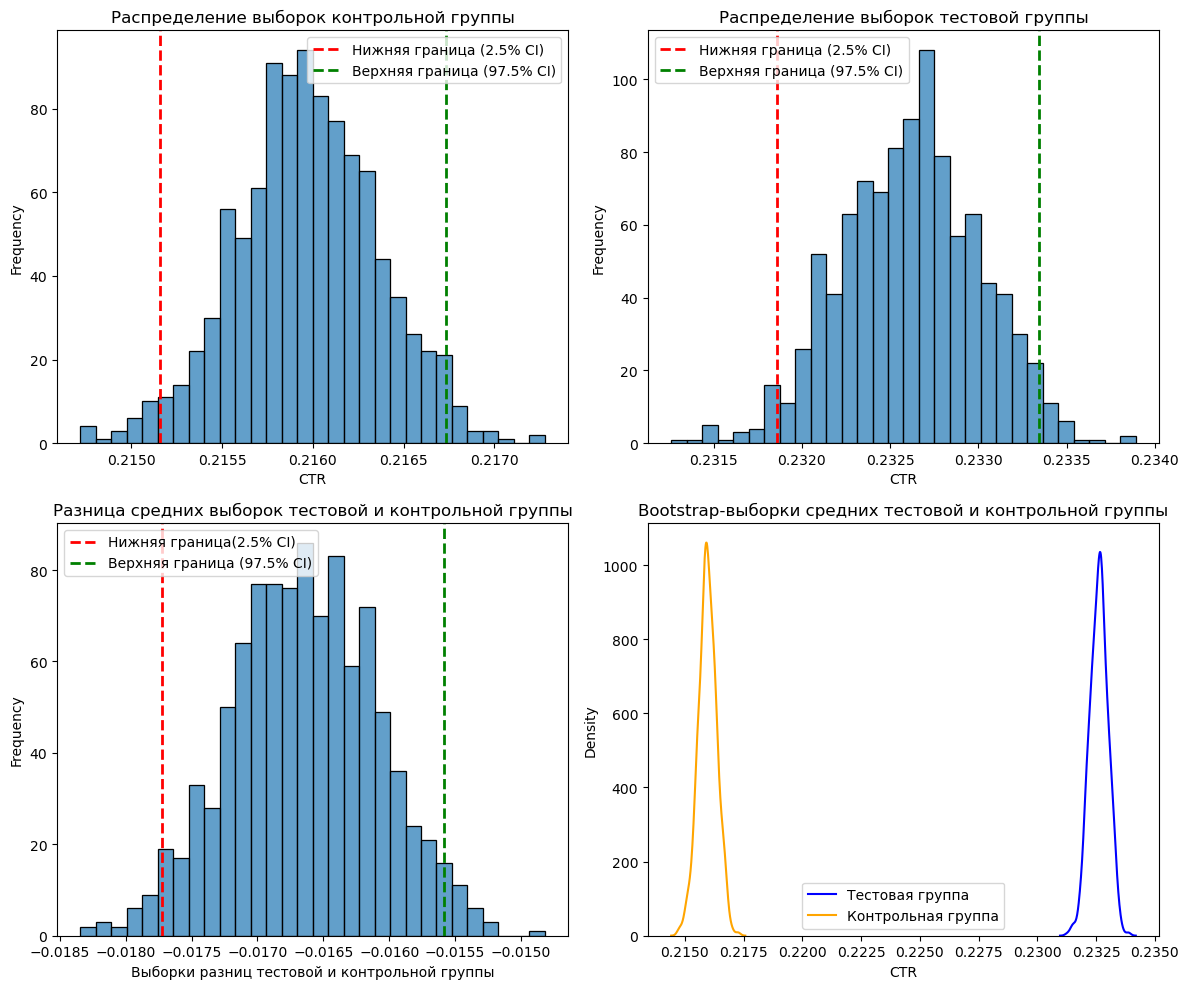

In [57]:
ci_test, ci_control, ci_diff = bootstrap_and_plot(user_data)

In [58]:
# Выводим результаты
print(f"Доверительный интервал для тестовой группы: ({ci_test[0]:.3f}, {ci_test[1]:.3f})")
print(f"Доверительный интервал для контрольной группы: ({ci_control[0]:.3f}, {ci_control[1]:.3f})")
print(
    f"Доверительный интервал для разницы средних: ({ci_diff[0]:.3f}, {ci_diff[1]:.3f})"
)

# Проверяем статистическую значимость разницы средних
if ci_diff[0] > 0 or ci_diff[1] < 0:
    print("Разница средних статистически значима.")
else:
    print("Разница средних не является статистически значимой.")

Доверительный интервал для тестовой группы: (0.232, 0.233)
Доверительный интервал для контрольной группы: (0.215, 0.217)
Доверительный интервал для разницы средних: (-0.018, -0.016)
Разница средних статистически значима.


### Итог по bootstrap-у

Доверительный интервал для разницы средних не включает 0, следовательно мы отвергаем нулевую гипотезу, 
также графически мы можем увидеть разницу более отчетливо.  
Можно уверенно сделать вывод, что система рекомендаций, основанная на лайках похожих людей работает лучше старой и эксперимент можно считать удачным.   
Алгоритм можно запускать в продакшн.

# Общий вывод

Мы провели эксперимент и выявили следующие ключевые особенности:  

1. Уникальных пользователей: были активными 20048 уникальных пользователей, что позволяет сделать вывод о достаточном представительстве данных для анализа.

2. Гендерное распределение: около 55% пользователей - мужчины, а остальные - женщины. Это говорит о том, что платформа имеет равное распределение по половому признаку.

3. Национальное распределение: около 88% пользователей из России, что позволяет сделать вывод о том, что аудитория в основном состоит из россиян.

4. Возрастное распределение: около половины пользователей - молодые люди в возрасте 18-25 лет. Это говорит о том, что платформа особенно привлекательна для молодой аудитории.

5. Городское распределение: большинство пользователей из таких городов, как Москва, Санкт-Петербург, Новосибирск, Екатеринбург, Казань. Это говорит о том, что аудитория в основном состоит из жителей крупных городов России.

6. Временное распределение: пик активности пользователей приходится на период с 16 до 21 часа, после чего начинается спад активности. Это позволяет сделать вывод о том, что аудитория активна в вечернее время.

7. Операционная система: 65% пользователей используют платформу Android, а остальные - iOS. Это говорит о том, что аудитория в основном использует мобильные устройства на базе Android.

8. Группы эксперимента: вы обнаружили, что пользователи во время эксперимента были разбиты поровну на тестовую и контрольную группы. Это позволяет сделать вывод о том, что эксперимент был проведен с использованием контрольной группы для сравнения результатов.

9. T-тест Стьюдента: мы не смогли применить T-тест из-за несоблюдения условий о нормальности распределения и гомогенности дисперсии. Это говорит о том, что данные не удовлетворяют предпосылкам для применения T-теста, и необходимо использовать другие статистические методы для анализа данных.

10. Тест Манна-Уитни: мы использовали тест Манна-Уитни, который дал результат о том, что разница между группами статистически значима, и система рекомендаций повышает метрику CTR. Это говорит о том, что система рекомендаций имеет положительный эффект на метрику CTR и может быть использована для улучшения качества рекомендаций.

11. Метод бутстрепа: мы использовали метод бутстрепа, который также подтвердил, что система рекомендаций, основанная на лайках похожих людей, работает лучше старой. Это говорит о том, что новая система рекомендаций имеет более высокую эффективность, чем старая.  
  
**Вывод:** эксперимент можно считать удачным, так как ваша новая система рекомендаций показала положительный эффект на метрику CTR и имеет более высокую эффективность, чем старая система рекомендаций. Следует использовать полученные результаты для дальнейшего улучшения системы рекомендаций и повышения качества рекомендаций для аудитории.